In [28]:
!pip install --quiet transformers tensorflow tensorflowjs

In [29]:
import os
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import json, random, math, itertools, gc, re, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import mixed_precision
from tensorflow.keras.callbacks import EarlyStopping
from transformers import (
    DistilBertTokenizer,
    TFDistilBertForSequenceClassification,
    DistilBertConfig,
)
from tensorflow.keras.callbacks import Callback
from sklearn.model_selection import train_test_split

from tqdm import tqdm


SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

mixed_precision.set_global_policy("mixed_float16")

tf.config.optimizer.set_jit(True)

gpus = tf.config.list_physical_devices("GPU")
print(f"GPUs detected: {len(gpus)} → {gpus}")

DATASET_PATH = "/kaggle/input/testingsa/News_Category_Dataset_v3.json"
LABELS_PATH  = "labels.json"
MODEL_NAME   = "distilbert-base-uncased"

MAX_LEN      = 128
NUM_LABELS   = 42
BATCH_SIZE   = 32
EPOCHS       = 20
LR           = 2e-5
ES_PATIENCE  = 2

### Load labels from labels.json

In [31]:
with open(LABELS_PATH) as f:
    idx2label = json.load(f)
label2idx = {v: k for k, v in enumerate(idx2label)}
assert len(idx2label) == NUM_LABELS, "labels.json has different size!"
print(label2idx)

{'ARTS': 0, 'ARTS & CULTURE': 1, 'BLACK VOICES': 2, 'BUSINESS': 3, 'COLLEGE': 4, 'COMEDY': 5, 'CRIME': 6, 'CULTURE & ARTS': 7, 'DIVORCE': 8, 'EDUCATION': 9, 'ENTERTAINMENT': 10, 'ENVIRONMENT': 11, 'FIFTY': 12, 'FOOD & DRINK': 13, 'GOOD NEWS': 14, 'GREEN': 15, 'HEALTHY LIVING': 16, 'HOME & LIVING': 17, 'IMPACT': 18, 'LATINO VOICES': 19, 'MEDIA': 20, 'MONEY': 21, 'PARENTING': 22, 'PARENTS': 23, 'POLITICS': 24, 'QUEER VOICES': 25, 'RELIGION': 26, 'SCIENCE': 27, 'SPORTS': 28, 'STYLE': 29, 'STYLE & BEAUTY': 30, 'TASTE': 31, 'TECH': 32, 'THE WORLDPOST': 33, 'TRAVEL': 34, 'U.S. NEWS': 35, 'WEDDINGS': 36, 'WEIRD NEWS': 37, 'WELLNESS': 38, 'WOMEN': 39, 'WORLD NEWS': 40, 'WORLDPOST': 41}


### Preprocessing dataset

In [ ]:
df = pd.read_json(DATASET_PATH, lines=True)
df = df[["headline", "short_description", "category"]]
df["text"]   = (df.headline.str.strip() + ". " + df.short_description.str.strip()).str.strip()
df["label"]  = df.category.map(label2idx)

df = df[["text", "label"]].dropna()
print("Dataset size:", len(df))
df.head()

Dataset size: 209527


,text,label
0,Over 4 Million Americans Roll Up Sleeves For O...,35
1,"American Airlines Flyer Charged, Banned For Li...",35
2,23 Of The Funniest Tweets About Cats And Dogs ...,5
3,The Funniest Tweets From Parents This Week (Se...,22
4,Woman Who Called Cops On Black Bird-Watcher Lo...,35


### Split data to train and validation sets

In [ ]:
train_df, val_df = train_test_split(
    df, test_size=0.1, stratify=df.label, random_state=SEED
)
print(f"Train: {len(train_df):,}  |  Val: {len(val_df):,}")

Train: 188,574  |  Val: 20,953


### Tokenizing data

In [34]:
# ─── Cell 6: Tokenizer & Optimized tf.data Pipeline ───
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
AUTOTUNE   = tf.data.AUTOTUNE

def df_to_dataset(df, shuffle=True, batch_size=BATCH_SIZE):
    encodings = tokenizer(
        df.text.tolist(),
        padding="max_length",
        truncation=True,
        max_length=MAX_LEN,
        return_tensors="tf",
    )
    labels = tf.convert_to_tensor(df.label.values, dtype=tf.int32)

    ds = tf.data.Dataset.from_tensor_slices((dict(encodings), labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df), seed=SEED)
    return (
        ds
        .cache()                  # cache in memory after first epoch
        .batch(batch_size)
        .prefetch(AUTOTUNE)       # overlap preprocessing + training
    )

train_ds         = df_to_dataset(train_df, shuffle=True)
val_ds           = df_to_dataset(val_df,   shuffle=False)
train_ds_to_fit  = train_ds.repeat()
val_ds_to_fit    = val_ds.repeat()

### Model building & compiling

In [ ]:
es = EarlyStopping(
    monitor="val_loss",
    patience=ES_PATIENCE,
    restore_best_weights=True,
    verbose=1,
)

strategy = tf.distribute.MirroredStrategy()
print("Num replicas:", strategy.num_replicas_in_sync)

with strategy.scope():
    config = DistilBertConfig.from_pretrained(
        MODEL_NAME,
        num_labels=NUM_LABELS,
        output_attentions=True,
        problem_type="single_label_classification",
    )
    model = TFDistilBertForSequenceClassification.from_pretrained(
        MODEL_NAME, config=config
    )

    for layer in model.distilbert.transformer.layer[:-2]:
        layer.trainable = False

    optimizer = tf.keras.optimizers.Adam(learning_rate=LR)
    loss_fn   = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    model.compile(
        optimizer=optimizer,
        loss=loss_fn,
        metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name="accuracy")],
    )

print("model compiled")
print("trainable params:",
      sum(np.prod(v.shape) for v in model.trainable_variables)//1000, "K")

### Defining callback for user prompt when epoch is ending

In [36]:
class UserPromptCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        acc = logs.get("accuracy")
        loss = logs.get("loss")
        val_acc = logs.get("val_accuracy")
        val_loss = logs.get("val_loss")
        print(f"\nEpoch {epoch+1} ➞ loss={loss:.4f}, acc={acc:.4f}, val_loss={val_loss:.4f}, val_acc={val_acc:.4f}")
        
        ans = input("Continue training? [y/N]: ").strip().lower()
        if ans not in ("y", "yes"):
            print("stopping training")
            self.model.stop_training = True

### Model training

In [37]:
user_prompt = UserPromptCallback()
history = model.fit(
    train_ds_to_fit,
    validation_data=val_ds_to_fit,
    epochs=EPOCHS,
    steps_per_epoch=math.ceil(len(train_df)/BATCH_SIZE),
    validation_steps=math.ceil(len(val_df)/BATCH_SIZE),
    callbacks=[es, user_prompt],
    verbose=2,
)

Epoch 1/20

Epoch 1 ➞ loss=1.3923, acc=0.6140, val_loss=1.0934, val_acc=0.6768
5893/5893 - 875s - loss: 1.3923 - accuracy: 0.6140 - val_loss: 1.0934 - val_accuracy: 0.6768 - 875s/epoch - 149ms/step
Epoch 2/20

Epoch 2 ➞ loss=1.0020, acc=0.7017, val_loss=1.0081, val_acc=0.6945
5893/5893 - 1085s - loss: 1.0020 - accuracy: 0.7017 - val_loss: 1.0081 - val_accuracy: 0.6945 - 1085s/epoch - 184ms/step
Epoch 3/20

Epoch 3 ➞ loss=0.8514, acc=0.7408, val_loss=0.9802, val_acc=0.7056
5893/5893 - 842s - loss: 0.8514 - accuracy: 0.7408 - val_loss: 0.9802 - val_accuracy: 0.7056 - 842s/epoch - 143ms/step
Epoch 4/20

Epoch 4 ➞ loss=0.7300, acc=0.7747, val_loss=0.9913, val_acc=0.7079
5893/5893 - 848s - loss: 0.7300 - accuracy: 0.7747 - val_loss: 0.9913 - val_accuracy: 0.7079 - 848s/epoch - 144ms/step
Epoch 5/20

Epoch 5 ➞ loss=0.6190, acc=0.8071, val_loss=1.0354, val_acc=0.7005
5893/5893 - 834s - loss: 0.6190 - accuracy: 0.8071 - val_loss: 1.0354 - val_accuracy: 0.7005 - 834s/epoch - 142ms/step
Epoch 5:

### Model exporting

In [ ]:
EXPORT_DIR = "saved_model"
os.makedirs(EXPORT_DIR, exist_ok=True)

class ExportModule(tf.Module):
    def __init__(self, model):
        super().__init__()
        self.embed_layer     = model.get_input_embeddings()
        self.distilbert      = model.distilbert
        self.pre_classifier  = model.pre_classifier
        self.dropout         = model.dropout
        self.classifier      = model.classifier

    @tf.function(input_signature=[
        tf.TensorSpec([None, None], tf.int32, name="input_ids"),
        tf.TensorSpec([None, None], tf.int32, name="attention_mask"),
    ])
    def serve(self, input_ids, attention_mask):
        embeds = self.embed_layer(input_ids)

        with tf.GradientTape() as tape:
            tape.watch(embeds)

            bert_out = self.distilbert(
                None,
                attention_mask=attention_mask,
                inputs_embeds=embeds,
                training=False,
            )
            hidden = bert_out.last_hidden_state

            cls_token = hidden[:, 0, :]
            x = self.pre_classifier(cls_token)
            x = tf.nn.relu(x)
            x = self.dropout(x, training=False)
            logits = self.classifier(x)
            probs = tf.nn.softmax(logits, axis=-1)

            preds = tf.argmax(probs, axis=-1, output_type=tf.int32)
            batch_idx = tf.range(tf.shape(preds)[0], dtype=tf.int32)
            pred_logits = tf.gather_nd(
                logits, tf.stack([batch_idx, preds], axis=1)
            )

        grads = tape.gradient(pred_logits, embeds)
        token_importance = tf.norm(grads, axis=-1)

        return {
            "probabilities": probs,
            "token_importance": token_importance,
        }

tokenizer.save_pretrained(EXPORT_DIR)
with open(os.path.join(EXPORT_DIR, "idx2label.json"), "w") as f:
    json.dump(idx2label, f, indent=4)

export_module = ExportModule(model)
tf.saved_model.save(
    export_module,
    EXPORT_DIR,
    signatures={"serving_default": export_module.serve}
)

print(f"export completed into '{EXPORT_DIR}'")

In [50]:
!zip -r saved_model_2.zip saved_model

  adding: saved_model/ (stored 0%)
  adding: saved_model/tokenizer_config.json (deflated 75%)
  adding: saved_model/variables/ (stored 0%)
  adding: saved_model/variables/variables.index (deflated 74%)
  adding: saved_model/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: saved_model/vocab.txt (deflated 53%)
  adding: saved_model/idx2label.json (deflated 63%)
  adding: saved_model/fingerprint.pb (stored 0%)
  adding: saved_model/special_tokens_map.json (deflated 42%)
  adding: saved_model/assets/ (stored 0%)
  adding: saved_model/saved_model.pb (deflated 92%)


### Visualisations (confusion matrix, classification report, ROC curves and training history)

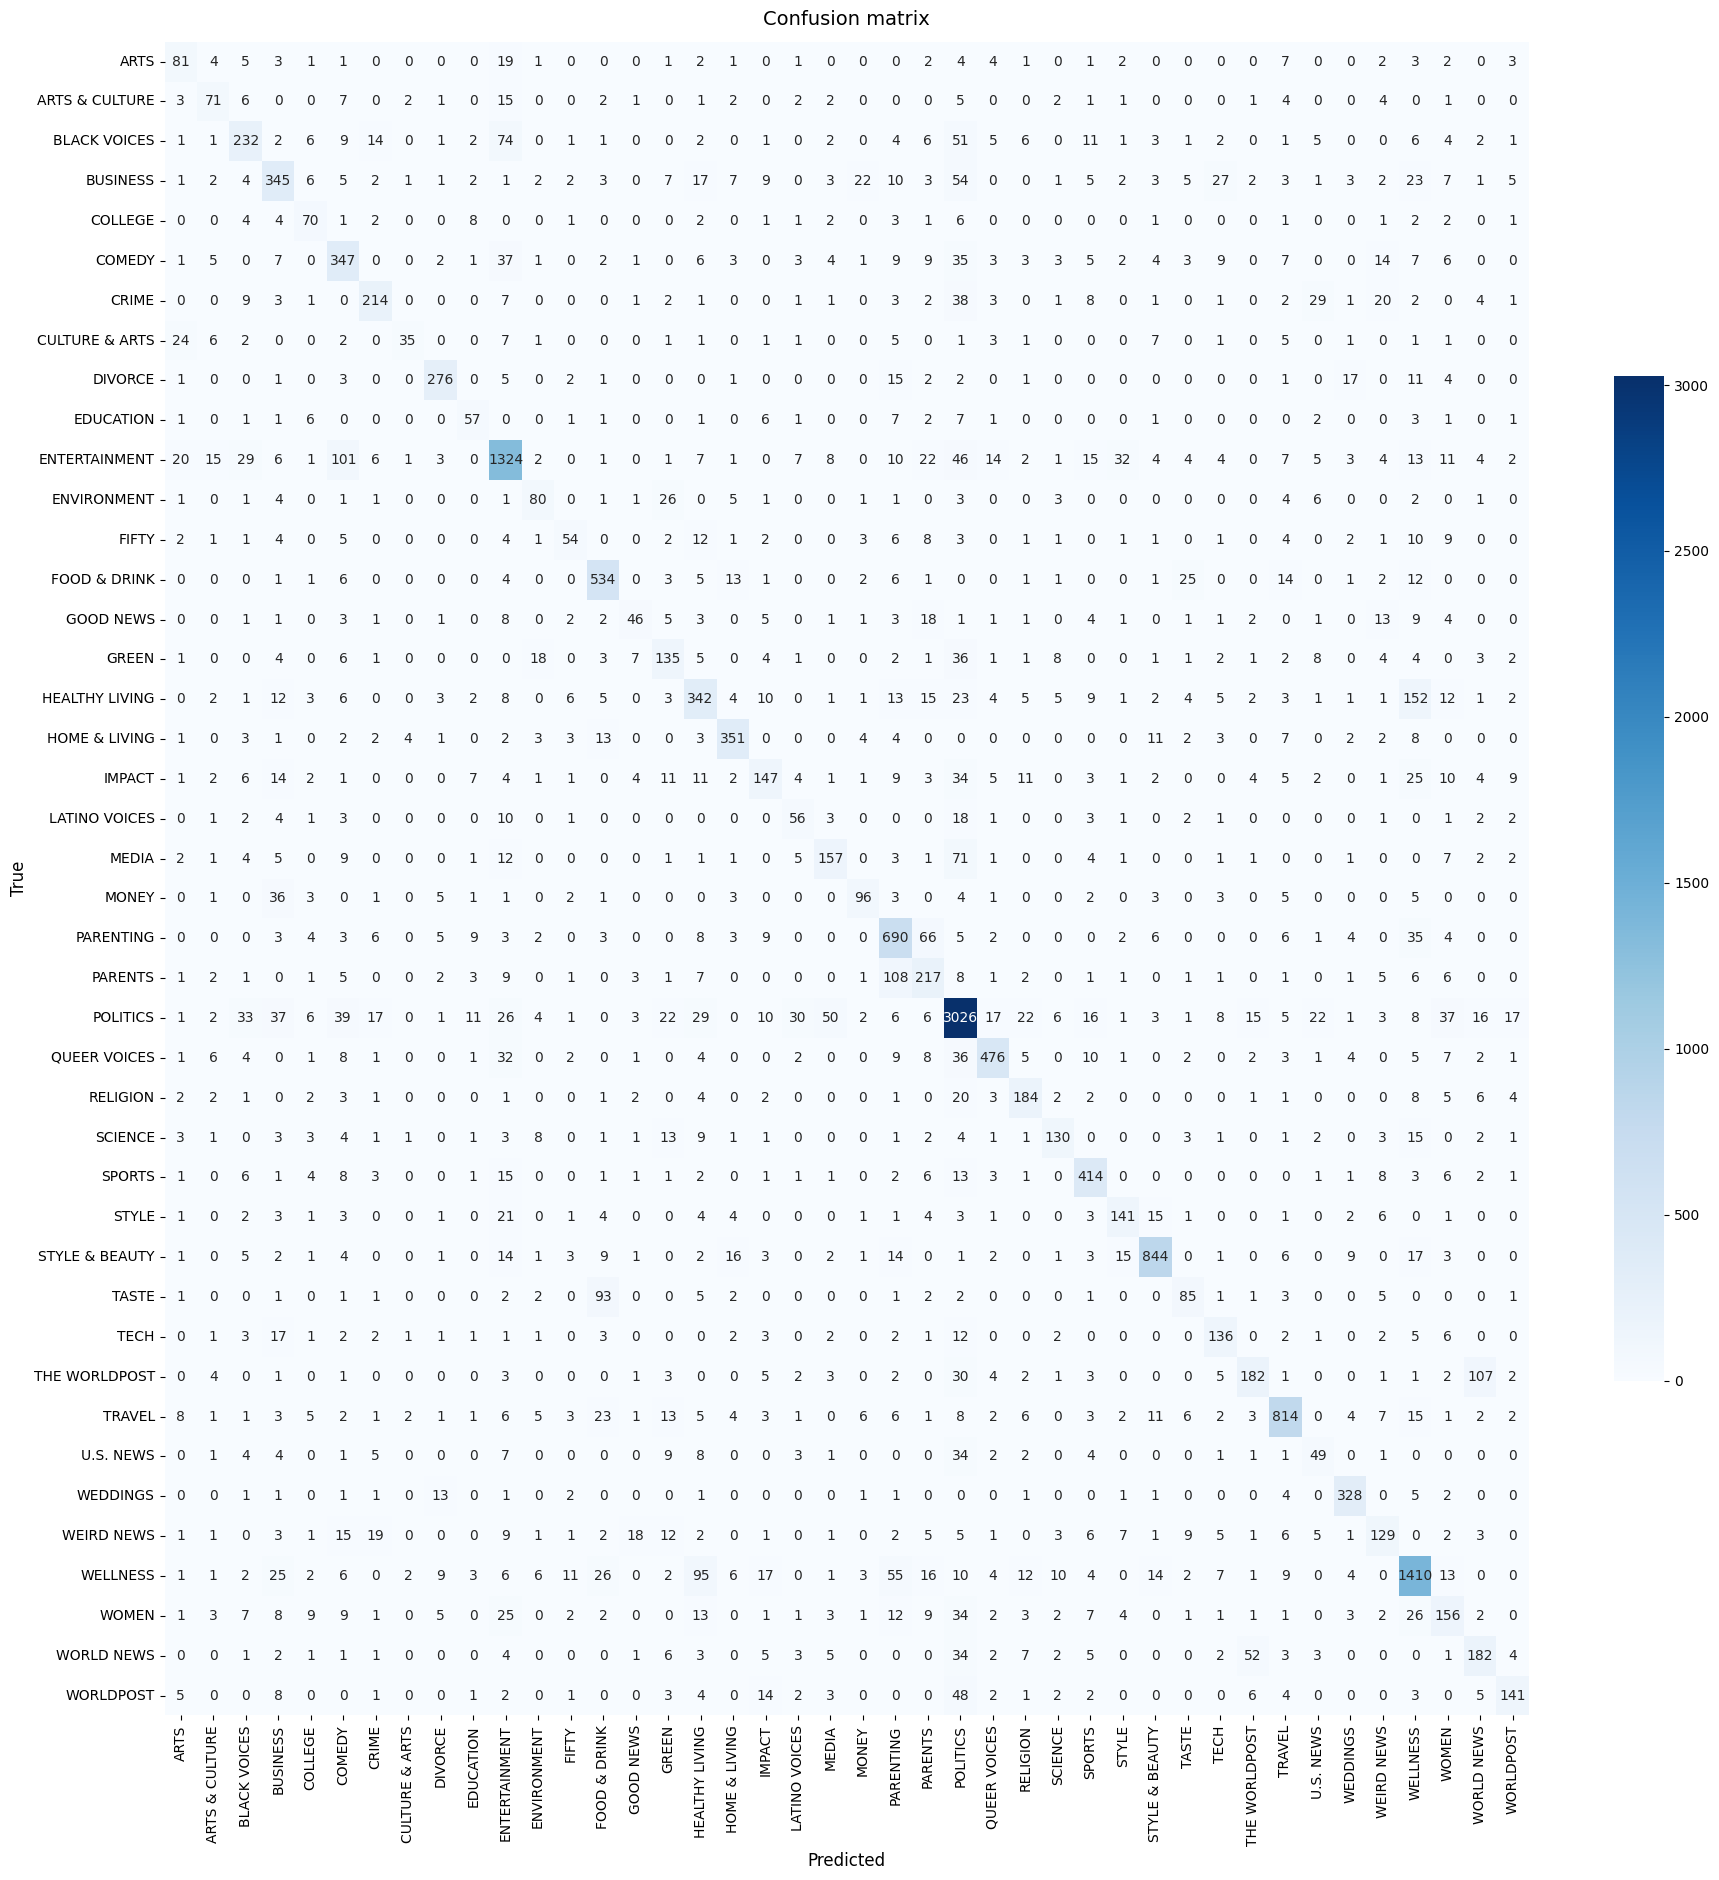


Classification report
 class               prec   recall     f1   support
─────────────────────────────────────────────────────
 ARTS                0.479    0.536   0.506      151
 ARTS & CULTURE      0.518    0.530   0.524      134
 BLACK VOICES        0.607    0.507   0.552      458
 BUSINESS            0.595    0.576   0.585      599
 COLLEGE             0.490    0.614   0.545      114
 COMEDY              0.547    0.643   0.591      540
 CRIME               0.702    0.601   0.648      356
 CULTURE & ARTS      0.714    0.327   0.449      107
 DIVORCE             0.829    0.805   0.817      343
 EDUCATION           0.504    0.564   0.533      101
 ENTERTAINMENT       0.764    0.763   0.763     1736
 ENVIRONMENT         0.571    0.556   0.563      144
 FIFTY               0.519    0.386   0.443      140
 FOOD & DRINK        0.724    0.842   0.778      634
 GOOD NEWS           0.489    0.329   0.393      140
 GREEN               0.477    0.515   0.495      262
 HEALTHY LIVING      0.

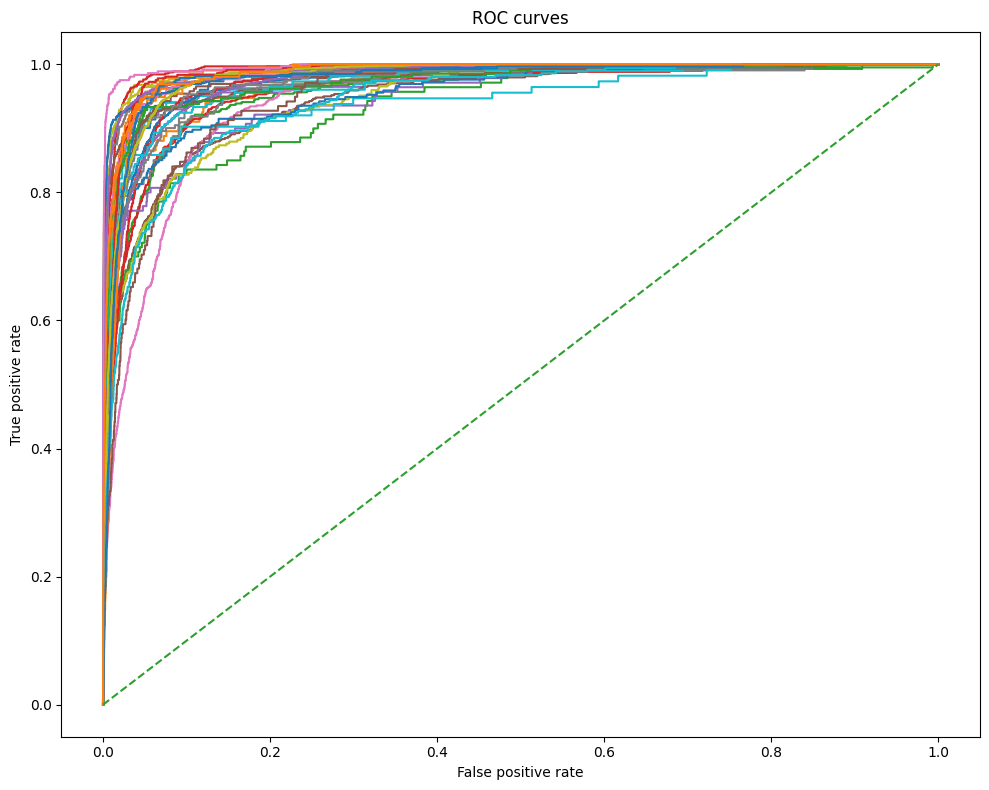


Average AUC across 42 classes: 0.9723 (min 0.9346, max 0.9964)


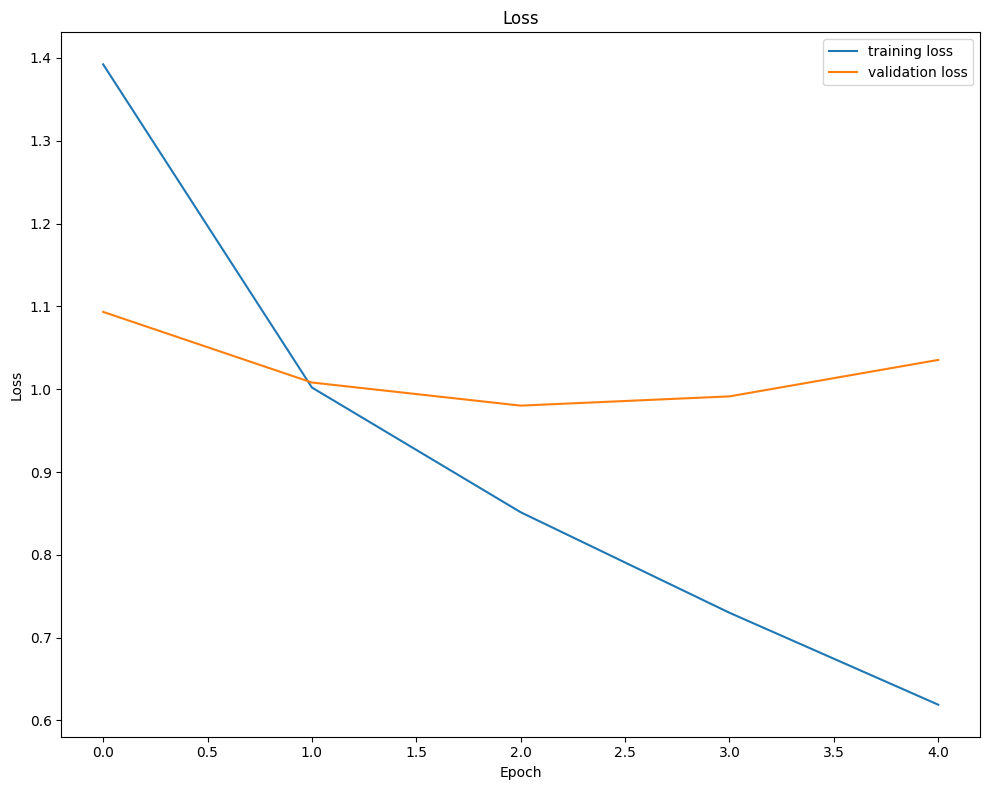

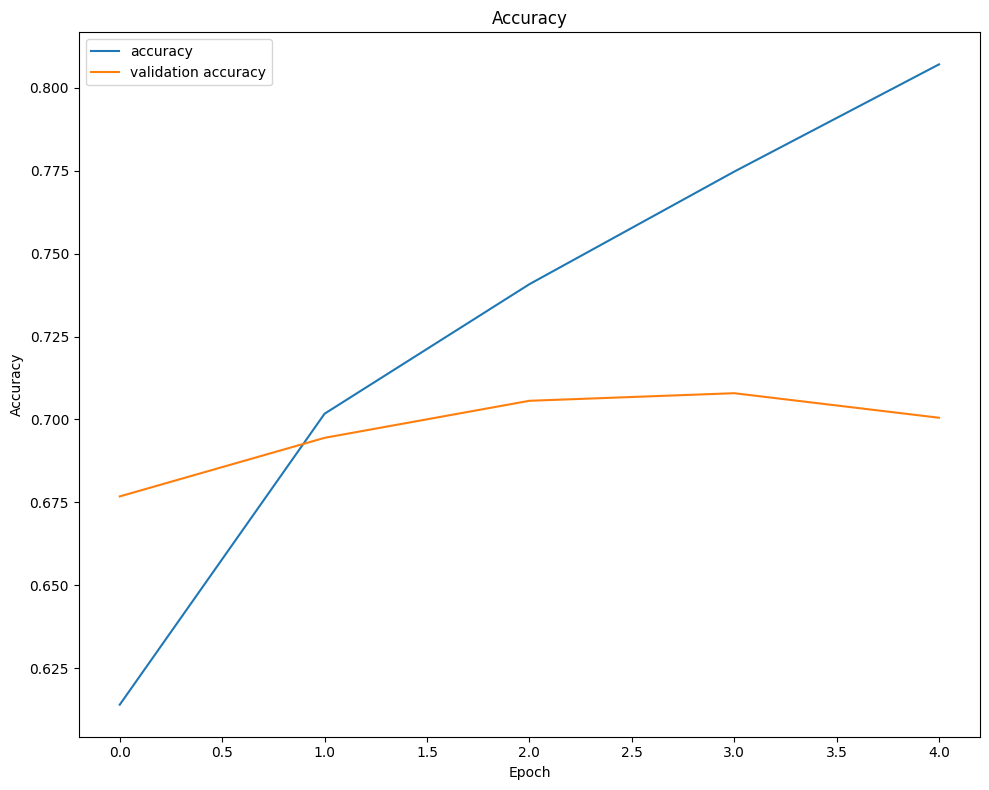

In [ ]:
def conf_matrix(y_true, y_pred, num_classes):
    cm = np.zeros((num_classes, num_classes), dtype=np.int64)
    for t, p in zip(y_true, y_pred):
        cm[t, p] += 1
    return cm

def classification_report(cm):
    tp = np.diag(cm)
    fp = cm.sum(0) - tp
    fn = cm.sum(1) - tp
    support = cm.sum(1)

    precision = np.divide(tp, tp + fp, out=np.zeros_like(tp, dtype=float), where=(tp + fp)!=0)
    recall = np.divide(tp, tp + fn, out=np.zeros_like(tp, dtype=float), where=(tp + fn)!=0)
    f1 = np.divide(2 * precision * recall, precision + recall, out=np.zeros_like(tp, dtype=float), where=(precision + recall) != 0)
    return precision, recall, f1, support

def roc_curves(y_true_bin, y_score):
    desc_score_indices = np.argsort(-y_score)
    y_score = y_score[desc_score_indices]
    y_true_bin = y_true_bin[desc_score_indices]

    tps = np.cumsum(y_true_bin)
    fps = np.cumsum(1 - y_true_bin)

    tpr = tps / tps[-1] if tps[-1] > 0 else np.zeros_like(tps, dtype=float)
    fpr = fps / fps[-1] if fps[-1] > 0 else np.zeros_like(fps, dtype=float)

    tpr = np.concatenate([[0.0], tpr, [1.0]])
    fpr = np.concatenate([[0.0], fpr, [1.0]])
    return fpr, tpr


def make_plots(model, val_ds, class_names, history=None):
    # collect logits and labels
    y_probs, y_trues = [], []

    for _, (x_batch, y_batch) in enumerate(val_ds):
        # squeeze & cast to int32
        x_batch = {
            k: tf.cast(tf.squeeze(v, axis=-1) if v.shape.rank == 3 else v, tf.int32)
            for k, v in x_batch.items()
        }

        out = model(x_batch, training=False)
        if isinstance(out, dict):
            logits = out["logits"]
        elif hasattr(out, "logits"):
            logits = out.logits
        else:
            logits = out
            
        y_probs.append(logits.numpy())
        if isinstance(y_batch, tf.Tensor):
            y_trues.append(y_batch.numpy())
        elif isinstance(y_batch, dict):
            label_tensor = y_batch.get("labels")
            if label_tensor is None:
                label_tensor = next(iter(y_batch.values()))
            y_trues.append(label_tensor.numpy())
        else:
            y_trues.append(np.asarray(y_batch))

    y_prob = np.concatenate(y_probs, axis=0)
    y_true = np.concatenate(y_trues, axis=0)
    y_pred = np.argmax(y_prob, axis=1)
    num_classes = len(class_names)

    # confusion matrix
    cm = conf_matrix(y_true, y_pred, num_classes)

    cell_size = 0.45
    fig_w = max(8, num_classes * cell_size)
    fig_h = fig_w

    plt.figure(figsize=(fig_w, fig_h))
    sns.heatmap(cm,
                annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={"shrink": 0.6})
    plt.title("Confusion matrix", fontsize=14, pad=12)
    plt.xlabel("Predicted", fontsize=12)
    plt.ylabel("True", fontsize=12)
    plt.xticks(rotation=90, fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig("conf_matrix.png", bbox_inches="tight")
    plt.show()

    # classification report
    prec, rec, f1, sup = classification_report(cm)

    print("\nClassification report")
    print(" class               prec   recall     f1   support")
    print("─────────────────────────────────────────────────────")
    for i, name in enumerate(class_names):
        print(f" {name:<18} {prec[i]:6.3f}  {rec[i]:7.3f}  {f1[i]:6.3f}   {sup[i]:6d}")
    print("─────────────────────────────────────────────────────")
    micro_f1 = f1 @ sup / sup.sum()
    print(f" micro-avg                           {micro_f1:6.3f}   {sup.sum():6d}")

    # ROC curves
    plt.figure(figsize=(10, 8))
    aucs = []

    y_true_bin = np.eye(num_classes, dtype=int)[y_true]

    for i in range(num_classes):
        fpr, tpr = roc_curves(y_true_bin[:, i], y_prob[:, i])
        aucs.append(np.trapz(tpr, fpr))
        plt.plot(fpr, tpr)

    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.title("ROC curves")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.tight_layout()
    plt.savefig("roc_curves.png", bbox_inches="tight")
    plt.show()

    print(f"\nAverage AUC across {num_classes} classes: {np.mean(aucs):.4f} (min {np.min(aucs):.4f}, max {np.max(aucs):.4f})")

    # training history
    hist = history.history

    plt.figure(figsize=(10, 8))
    plt.plot(hist["loss"], label="training loss")
    plt.plot(hist["val_loss"], label="validation loss")
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.tight_layout()
    plt.savefig("loss_history.png", bbox_inches="tight")
    plt.show()

    plt.figure(figsize=(10, 8))
    plt.plot(hist["accuracy"], label="accuracy")
    plt.plot(hist["val_accuracy"], label="validation accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.tight_layout()
    plt.savefig("accuracy_history.png", bbox_inches="tight")
    plt.show()


make_plots(model, val_ds, idx2label, history=history)

In [ ]:
# save images
!mkdir images
!mv conf_matrix.png roc_curves.png loss_history.png accuracy_history.png images
!zip -r images.zip images